# Individualized speed zones

This article is an interactive guide to calculate the distance spent in individualized speed thresholds from GPS raw data. Individualized speed thresholds were calculated based on Rago et al. (2020). This notebook uses the programming language python.

## Optimized Functions 
First a few softwarepackages are imported into the script. Pandas is used to create a dataframe, in which the collected GPS data is organised. Numpy is a mathematical library to perform mathematical operations with the dataset(addition, subtraction, etc.). Matplotlib is a graphical package that is used to visualize the results.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

This first section provides an overview of the created functions. 

In [36]:
Tbl = pd.read_excel('MAS+MSS.xlsx')
os.chdir('data')
Files=os.listdir()

# Function takes file location as argument, returns array of speed and distance per time unit
def getSpeedAndDistance (File):  
    data=pd.read_csv(File)
    v=np.array(data['Geschwindigkeit [km/h]']) # speed in km/h
    s=np.array(data['Distanz [m]']) # cumulative distance
    ds=np.gradient(s) # distance per time unit
    return v, ds

# importing MAS & MSS, calculating speed zones in arrays
def getThreshold (Tbl,ID): 
    MAS=np.float64(Tbl.MAS[ID])
    MSS=np.float64(Tbl.MSS[ID])
    LowThresh=np.array([0 , 0.8*MAS , MAS , (MSS - MAS) * 0.29 + MAS])
    return LowThresh

# allocating distances into zones, outputing metres covered in Zones
def MetreInZones(LowThresh, v, ds): 
    HighThresh=np.append(LowThresh[1:],1e4)
    Metrezone = np.array([])
    for count in range (0, len(LowThresh)):
        e = (v >= LowThresh[count]) & (v < HighThresh[count])
        distancesInZone = e * ds
        Metrezone = np.append(Metrezone, np.sum(distancesInZone))
    return Metrezone

# calling the function for all Players defined in dictionary
for File in Files: 
    v,ds=getSpeedAndDistance(File)
    Thresh=getThreshold(Tbl,0)
    MetreInZones(Thresh,v,ds)

[0.   0.   0.   ... 0.1  0.15 0.2 ]
[0.   0.   0.   ... 0.05 0.1  0.1 ]
[0.   0.   0.   ... 0.1  0.15 0.2 ]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


## Step-by-Step Explanations
It is the first step to import the raw data into this script. The code also provides a figure plotting speed over time in order to receive a first overview of the data.

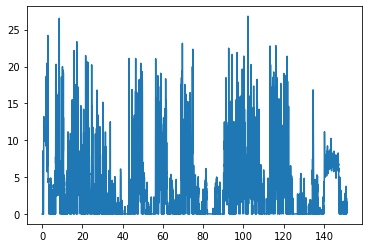

In [16]:
data = pd.read_csv(os.listdir()[1])                                         # importing raw data
time = np.arange(0, len(data['Geschwindigkeit [km/h]'])/10/60, 1/60/10)     # creating x-axis as time in minutes
plt.plot(time, data['Geschwindigkeit [km/h]'])                              # plotting speed

Based on Rago et al. (2020) the following speed-bands were defined:

$$
\begin{aligned}  
&& Zone~1: & ~<~0.8~*~Maximal~Aerobic~Speed~(MAS)  & \newline   
&& Zone~2: & ~~0.8~*~MAS~-~MAS & \newline 
&& Zone~3: & ~~MAS~-~0.29~*~Anaerobic~Speed~Reserve~(ASR) & \newline 
&& Zone~4: & ~>~0.29~*~ASR& \newline  
\end{aligned}
$$

Consequently the threshold for the different speed-bands must be calculated. The values for MAS and maximal sprint speed (MSS) are defined in the following lines of code.
The following lines of code alos provide the figure of speed over time with additional horizontal lines indicating the thresholds for the speed-bands.

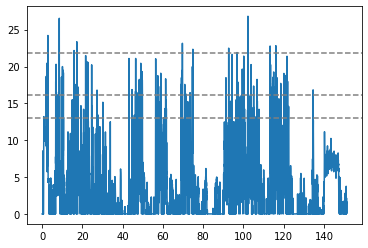

In [32]:
MAS = 16.2
MSS = 35.4
LowThresh=np.array([0 , 0.8*MAS , MAS , (MSS - MAS) * 0.29 + MAS])       # defining speed-bands based on MAS and MSS

plt.plot(time, data['Geschwindigkeit [km/h]'])                           # plotting speed
for n in range(1,4):
    plt.axhline(LowThresh[n], color="grey", linestyle="--")              # plotting horizontal lines as speed-band thresholds

Based on the provided figure it can be seen that the athlete spent most of the time in zone 1. It is the next step quantitatively calculate the distance covered in the different speed-bands. Therefore the distance per unit of time is calculated and afterwards the cumulative distance (left) and distance per unit of time (right) is visualized.

90718
90718
114364


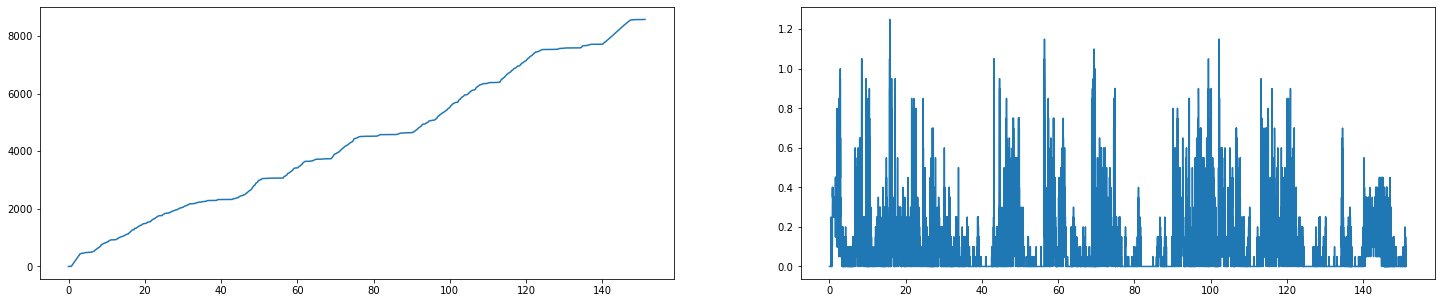

In [61]:
s=np.array(data['Distanz [m]'])                         # cumulative distance
ds=np.gradient(s)                                       # distance per unit of time
print(len(s))
print(len(ds))
print(len(v))

# Creating visualisation
plt.figure(figsize=(25,5))          
plt.subplot(1,2,1)  
plt.plot(time, s)
plt.subplot(1,2,2)
plt.plot(time, ds)

In the final step logical arrays are created for each speed-band and multiplied with the distance per unit of time. Afterwards the sum of each array yields the overall distance covered in each speed-band.

Text(0, 0.5, 'Distance covered [m]')

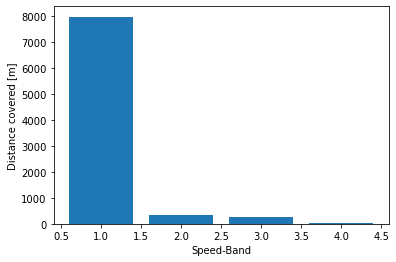

In [72]:
HighThresh=np.append(LowThresh[1:],1e4)
Metrezone = np.array([])
for count in range (0, len(LowThresh)):
    e = (v >= LowThresh[count]) & (v < HighThresh[count])               # finding values according to speed-band
    distancesInZone = e[0:90718] * ds                                   # multiplying logical array with distance per unit of time
    Metrezone = np.append(Metrezone, np.sum(distancesInZone))           # appending overall distance covered in speed-band to array

# Visualising the results
plt.bar([1,2,3,4], Metrezone)  
plt.xlabel('Speed-Band')     
plt.ylabel('Distance covered [m]')                                              

Inspecting the results it become apparent that the athlete spent most of the time in the lowest intensity zone. The following tool allows the reader to manipulate MAS and MSS and see the influence it has own distance covered in the speed-bands based on the definition from Rago et al. (2020). 

In [73]:
from ipywidgets import widgets

def Meters(MAS, MSS):
    LowThresh=np.array([0 , 0.8*MAS , MAS , (MSS - MAS) * 0.29 + MAS])      # calculating speed-bands thresholds
    HighThresh=np.append(LowThresh[1:],1e4)
    Metrezone = np.array([])
    for count in range (0, len(LowThresh)):
        e = (v >= LowThresh[count]) & (v < HighThresh[count])               # finding values according to speed-band
        distancesInZone = e[0:90718] * ds                                   # multiplying logical array with distance per unit of time
        Metrezone = np.append(Metrezone, np.sum(distancesInZone))           # appending overall distance covered in speed-band to array

    # Visualising the results
    plt.bar([1,2,3,4], Metrezone)  
    plt.xlabel('Speed-Band')     
    plt.ylabel('Distance covered [m]')      

widgets.interact(Meters, MAS=widgets.FloatSlider(value=10, min=1, max=30, step=1), MSS = widgets.FloatSlider(value = 30, min = 20, max = 40, step=1))                                        

interactive(children=(FloatSlider(value=10.0, description='MAS', max=30.0, min=1.0, step=1.0), FloatSlider(val…

<function __main__.Meters(MAS, MSS)>

# Summary

This notebook provides a practical guideline on how to individualize speed-bands based on GPS raw data. Our individualized speed-bands are set according to Rago et al. (2020). The developed functions are summarized in an optimized version at the beginning of the notebook.